In [454]:
# Run reviews_exploratiion.ipynb first.
import pandas as pd
import json
import ast
import numpy as np
import math
import missingno as msno
from dateutil import parser
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt

In [455]:
# Prevent printing scientific notation for latex tables.
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [456]:
# Load the reviews data.
games_reviews_long_df = pd.read_csv('games_reviews_flat.csv')
games_reviews_long_df.head()

,Unnamed: 0,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,...,percentile,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher,stock_id,date
0,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,83.00000,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub1_stock_id,10100,False,True,JP3435000009,2016-12-05
1,2506,119386,2020-11-30,Empire of Sin,empire-of-sin,True,True,False,Empire of Sin,Empire of Sin,...,20.00000,2020-12-01T00:00:00.000Z,2020-11-30T00:00:00.000Z,2023-02-01T00:00:00.000Z,pub1_stock_id,517,False,True,SE0008294953,2020-11-30
2,2508,119422,2019-09-10,eFootball PES 2020,efootball-pes-2020,False,True,True,eFootball PES 2020,eFootball PES 2020,...,83.00000,2019-09-10T00:00:00.000Z,2019-09-09T04:00:00.000Z,2019-10-09T00:00:00.000Z,dev1_stock_id,161,True,False,JP3300200007,2019-09-10
3,2510,119422,2019-09-10,eFootball PES 2020,efootball-pes-2020,False,True,True,eFootball PES 2020,eFootball PES 2020,...,83.00000,2019-09-10T00:00:00.000Z,2019-09-09T04:00:00.000Z,2019-10-09T00:00:00.000Z,pub1_stock_id,161,False,True,JP3300200007,2019-09-10
4,2514,120175,2020-02-27,One Punch Man: A Hero Nobody Knows,one-punch-man-a-hero-nobody-knows,False,True,True,One Punch Man: A Hero Nobody Knows,One-Punch Man: A Hero Nobody Knows,...,14.00000,2020-02-28T00:00:00.000Z,2017-05-21T00:00:00.000Z,2020-07-13T00:00:00.000Z,pub1_stock_id,248,False,True,JP3778630008,2020-02-27


In [457]:
# Drop unused columns.
columns_to_drop = ['Unnamed: 0', 'igdb_id', 'opencritic_id', 'first_release_date', 'slug', 'igdb_name', 'opencritic_name', 'firstReleaseDate', 'firstReviewDate', 'latestReviewDate', 'variable', 'igdb_company_id']
games_reviews_long_df = games_reviews_long_df.drop(columns_to_drop, axis = 1)

<Axes: >

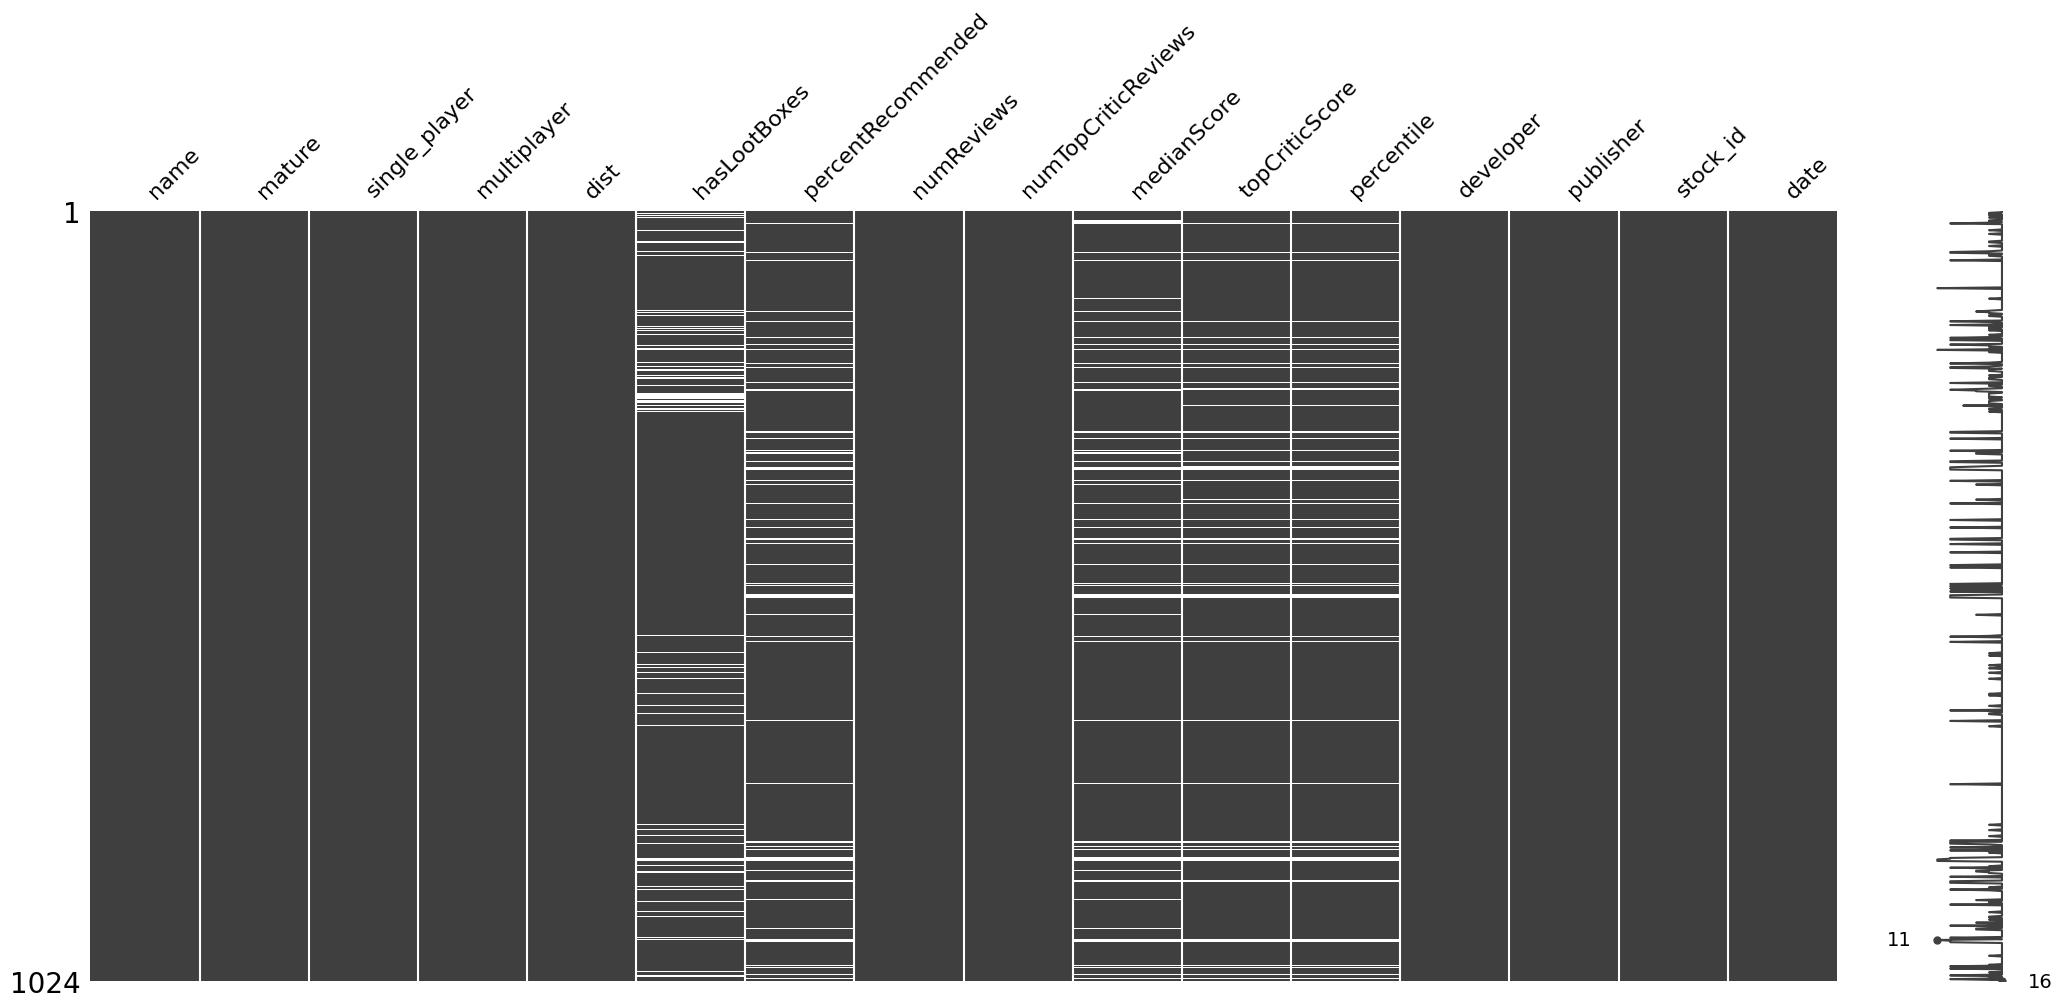

In [458]:
# Plot missing data.
%matplotlib inline

msno.matrix(games_reviews_long_df)

In [459]:
# stock_id is object and needs to be parsed as a string.
games_reviews_long_df['stock_id'] = games_reviews_long_df['stock_id'].astype('string')

In [460]:
# Parse first release date as datetime.
games_reviews_long_df['date'] = pd.to_datetime(games_reviews_long_df['date'], format='%Y-%m-%d')

In [461]:
games_reviews_long_df.dtypes

name                           object
mature                           bool
single_player                    bool
multiplayer                      bool
dist                          float64
hasLootBoxes                   object
percentRecommended            float64
numReviews                    float64
numTopCriticReviews           float64
medianScore                   float64
topCriticScore                float64
percentile                    float64
developer                        bool
publisher                        bool
stock_id               string[python]
date                   datetime64[ns]
dtype: object

In [462]:
games_reviews_long_df.head()

,name,mature,single_player,multiplayer,dist,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,topCriticScore,percentile,developer,publisher,stock_id,date
0,The Last Guardian,False,True,False,0.00000,False,70.49180,128.00000,96.00000,85.00000,80.52874,83.00000,False,True,JP3435000009,2016-12-05
1,Empire of Sin,True,True,False,0.00000,False,27.11864,60.00000,40.00000,62.50000,62.37838,20.00000,False,True,SE0008294953,2020-11-30
2,eFootball PES 2020,False,True,True,0.00000,NaN,79.10448,71.00000,48.00000,82.00000,81.27083,83.00000,True,False,JP3300200007,2019-09-10
3,eFootball PES 2020,False,True,True,0.00000,NaN,79.10448,71.00000,48.00000,82.00000,81.27083,83.00000,False,True,JP3300200007,2019-09-10
4,One Punch Man: A Hero Nobody Knows,False,True,True,0.00000,False,17.10526,76.00000,52.00000,60.00000,58.54902,14.00000,False,True,JP3778630008,2020-02-27


In [463]:
# # Parse first release date as datetime.
# games_reviews_long_df['date'] = pd.to_datetime(games_reviews_long_df['date'],unit='s', format='%Y-%m-%d')
games_reviews_long_df.dtypes

name                           object
mature                           bool
single_player                    bool
multiplayer                      bool
dist                          float64
hasLootBoxes                   object
percentRecommended            float64
numReviews                    float64
numTopCriticReviews           float64
medianScore                   float64
topCriticScore                float64
percentile                    float64
developer                        bool
publisher                        bool
stock_id               string[python]
date                   datetime64[ns]
dtype: object

In [464]:
games_reviews_long_df.head()

,name,mature,single_player,multiplayer,dist,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,topCriticScore,percentile,developer,publisher,stock_id,date
0,The Last Guardian,False,True,False,0.00000,False,70.49180,128.00000,96.00000,85.00000,80.52874,83.00000,False,True,JP3435000009,2016-12-05
1,Empire of Sin,True,True,False,0.00000,False,27.11864,60.00000,40.00000,62.50000,62.37838,20.00000,False,True,SE0008294953,2020-11-30
2,eFootball PES 2020,False,True,True,0.00000,NaN,79.10448,71.00000,48.00000,82.00000,81.27083,83.00000,True,False,JP3300200007,2019-09-10
3,eFootball PES 2020,False,True,True,0.00000,NaN,79.10448,71.00000,48.00000,82.00000,81.27083,83.00000,False,True,JP3300200007,2019-09-10
4,One Punch Man: A Hero Nobody Knows,False,True,True,0.00000,False,17.10526,76.00000,52.00000,60.00000,58.54902,14.00000,False,True,JP3778630008,2020-02-27


In [465]:
# Load the financial data.
stock_ff_index_df = pd.read_csv(
    'financial_data_clean.csv',
    dtype={
        'gvkey': int,
        'iid': 'string',
        'date': 'string',
        'company_name': 'string',
        'shares_outstanding': float,
        'trading_volume': float,
        'closing_price': float,
        'stock_id': 'string',
        'eu': bool,
        'jp': bool,
        'us': bool,
        'mkt-rf': float,
        'smb': float,
        'rmw': float,
        'cma': float,
        'rf': float,
        'benchmark_price': float,
        'returns': float,
        'benchmark_returns': float,
        'excess_return': float,
        'NOKUSD': float,
        'GBPUSD': float,
        'JPYUSD': float,
        'SEKUSD': float,
        'PLNUSD': float,
        'EURUSD': float,
        'market_cap': float,
        'mkt_cap_usd': float,
        'volume_to_shares_outstanding': float
    })
stock_ff_index_df.head()

,Unnamed: 0,gvkey,iid,date,company_name,shares_outstanding,trading_volume,closing_price,stock_id,eu,...,excess_return,NOKUSD,GBPUSD,JPYUSD,SEKUSD,PLNUSD,EURUSD,market_cap,mkt_cap_usd,volume_to_shares_outstanding
0,0,212596,01W,2015-10-01,UBI SOFT ENTERTAINMENT SA,111218465.00000,506501.00000,18.42000,FR0000054470,True,...,NaN,0.11869,1.51540,0.00836,0.11985,0.26381,1.12040,2048644125.30000,2295300877.98612,0.00455
1,1,212596,01W,2015-10-02,UBI SOFT ENTERTAINMENT SA,111218465.00000,217260.00000,18.15500,FR0000054470,True,...,-0.02009,0.12001,1.52015,0.00839,0.12024,0.26510,1.12755,2019171232.07500,2276716522.72617,0.00195
2,2,212596,01W,2015-10-05,UBI SOFT ENTERTAINMENT SA,111218465.00000,267647.00000,18.35500,FR0000054470,True,...,-0.01787,0.11910,1.51770,0.00831,0.12022,0.26422,1.12115,2041414925.07500,2288732343.24784,0.00241
3,3,212596,01W,2015-10-06,UBI SOFT ENTERTAINMENT SA,111218465.00000,984676.00000,19.90000,FR0000054470,True,...,0.07938,0.12058,1.52115,0.00832,0.12126,0.26493,1.12630,2213247453.50000,2492780606.87705,0.00885
4,4,212596,01W,2015-10-07,UBI SOFT ENTERTAINMENT SA,111218465.00000,740257.00000,20.12000,FR0000054470,True,...,0.01470,0.12177,1.53145,0.00834,0.12126,0.26536,1.12370,2237715515.80000,2514520925.10446,0.00666


In [466]:
# Parse first release date as datetime.
stock_ff_index_df['date'] = pd.to_datetime(stock_ff_index_df['date'], format='%Y-%m-%d')

In [467]:
stock_ff_index_df.columns

Index(['Unnamed: 0', 'gvkey', 'iid', 'date', 'company_name',
       'shares_outstanding', 'trading_volume', 'closing_price', 'stock_id',
       'eu', 'jp', 'us', 'mkt-rf', 'smb', 'hml', 'rmw', 'cma', 'rf',
       'benchmark_price', 'returns', 'benchmark_returns', 'excess_return',
       'NOKUSD', 'GBPUSD', 'JPYUSD', 'SEKUSD', 'PLNUSD', 'EURUSD',
       'market_cap', 'mkt_cap_usd', 'volume_to_shares_outstanding'],
      dtype='object')

In [468]:
# stock_id is object and needs to be parsed as a string.
stock_ff_index_df['stock_id'] = stock_ff_index_df['stock_id'].astype('string')

In [469]:
# Convert stock_data_df date column to datetime.
stock_ff_index_df['date'] = pd.to_datetime(stock_ff_index_df['date'])
stock_ff_index_df.dtypes

Unnamed: 0                               int64
gvkey                                    int64
iid                             string[python]
date                            datetime64[ns]
company_name                    string[python]
shares_outstanding                     float64
trading_volume                         float64
closing_price                          float64
stock_id                        string[python]
eu                                        bool
jp                                        bool
us                                        bool
mkt-rf                                 float64
smb                                    float64
hml                                    float64
rmw                                    float64
cma                                    float64
rf                                     float64
benchmark_price                        float64
returns                                float64
benchmark_returns                      float64
excess_return

In [470]:
stock_ff_index_df.head()

,Unnamed: 0,gvkey,iid,date,company_name,shares_outstanding,trading_volume,closing_price,stock_id,eu,...,excess_return,NOKUSD,GBPUSD,JPYUSD,SEKUSD,PLNUSD,EURUSD,market_cap,mkt_cap_usd,volume_to_shares_outstanding
0,0,212596,01W,2015-10-01,UBI SOFT ENTERTAINMENT SA,111218465.00000,506501.00000,18.42000,FR0000054470,True,...,NaN,0.11869,1.51540,0.00836,0.11985,0.26381,1.12040,2048644125.30000,2295300877.98612,0.00455
1,1,212596,01W,2015-10-02,UBI SOFT ENTERTAINMENT SA,111218465.00000,217260.00000,18.15500,FR0000054470,True,...,-0.02009,0.12001,1.52015,0.00839,0.12024,0.26510,1.12755,2019171232.07500,2276716522.72617,0.00195
2,2,212596,01W,2015-10-05,UBI SOFT ENTERTAINMENT SA,111218465.00000,267647.00000,18.35500,FR0000054470,True,...,-0.01787,0.11910,1.51770,0.00831,0.12022,0.26422,1.12115,2041414925.07500,2288732343.24784,0.00241
3,3,212596,01W,2015-10-06,UBI SOFT ENTERTAINMENT SA,111218465.00000,984676.00000,19.90000,FR0000054470,True,...,0.07938,0.12058,1.52115,0.00832,0.12126,0.26493,1.12630,2213247453.50000,2492780606.87705,0.00885
4,4,212596,01W,2015-10-07,UBI SOFT ENTERTAINMENT SA,111218465.00000,740257.00000,20.12000,FR0000054470,True,...,0.01470,0.12177,1.53145,0.00834,0.12126,0.26536,1.12370,2237715515.80000,2514520925.10446,0.00666


Begin by joining the reviews dataset with the financial dataset on release date and stock_id.

In [471]:
# Convert both dfs date columns to the same type.
stock_ff_index_df['date'] = pd.to_datetime(stock_ff_index_df['date'])
games_reviews_long_df['date'] = pd.to_datetime(games_reviews_long_df['date'])
# games_reviews_long_df['firstReviewDate'] = pd.to_datetime(games_reviews_long_df['firstReviewDate'], format="%Y-%m-%d")
# stock_ff_index_df.date = stock_ff_index_df['date'].astype('string')
# games_reviews_long_df.date = games_reviews_long_df['date'].astype('string')
# games_reviews_long_df.date = games_reviews_long_df['firstReviewDate'].astype('string')



In [472]:
games_reviews_long_df.dtypes

name                           object
mature                           bool
single_player                    bool
multiplayer                      bool
dist                          float64
hasLootBoxes                   object
percentRecommended            float64
numReviews                    float64
numTopCriticReviews           float64
medianScore                   float64
topCriticScore                float64
percentile                    float64
developer                        bool
publisher                        bool
stock_id               string[python]
date                   datetime64[ns]
dtype: object

In [473]:
games_reviews_long_df.head()

,name,mature,single_player,multiplayer,dist,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,topCriticScore,percentile,developer,publisher,stock_id,date
0,The Last Guardian,False,True,False,0.00000,False,70.49180,128.00000,96.00000,85.00000,80.52874,83.00000,False,True,JP3435000009,2016-12-05
1,Empire of Sin,True,True,False,0.00000,False,27.11864,60.00000,40.00000,62.50000,62.37838,20.00000,False,True,SE0008294953,2020-11-30
2,eFootball PES 2020,False,True,True,0.00000,NaN,79.10448,71.00000,48.00000,82.00000,81.27083,83.00000,True,False,JP3300200007,2019-09-10
3,eFootball PES 2020,False,True,True,0.00000,NaN,79.10448,71.00000,48.00000,82.00000,81.27083,83.00000,False,True,JP3300200007,2019-09-10
4,One Punch Man: A Hero Nobody Knows,False,True,True,0.00000,False,17.10526,76.00000,52.00000,60.00000,58.54902,14.00000,False,True,JP3778630008,2020-02-27


In [474]:
games_reviews_returns_df = pd.merge(games_reviews_long_df, stock_ff_index_df, how='left', on=['date', 'stock_id'])
games_reviews_returns_df.head()

,name,mature,single_player,multiplayer,dist,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,...,excess_return,NOKUSD,GBPUSD,JPYUSD,SEKUSD,PLNUSD,EURUSD,market_cap,mkt_cap_usd,volume_to_shares_outstanding
0,The Last Guardian,False,True,False,0.00000,False,70.49180,128.00000,96.00000,85.00000,...,-0.02238,0.11933,1.27050,0.00874,0.10919,0.23842,1.07250,3991703657600.00000,34891481671.08160,0.00533
1,Empire of Sin,True,True,False,0.00000,False,27.11864,60.00000,40.00000,62.50000,...,0.03711,0.11291,1.33505,0.00959,0.11696,0.26681,1.19620,27857280000.00000,3258243183.36000,0.00142
2,eFootball PES 2020,False,True,True,0.00000,NaN,79.10448,71.00000,48.00000,82.00000,...,-0.00755,0.11157,1.23535,0.00932,0.10300,0.25491,1.10410,659938416160.00000,6151285977.02736,0.00483
3,eFootball PES 2020,False,True,True,0.00000,NaN,79.10448,71.00000,48.00000,82.00000,...,-0.00755,0.11157,1.23535,0.00932,0.10300,0.25491,1.10410,659938416160.00000,6151285977.02736,0.00483
4,One Punch Man: A Hero Nobody Knows,False,True,True,0.00000,False,17.10526,76.00000,52.00000,60.00000,...,0.03723,0.10639,1.28735,0.00909,0.10361,0.25428,1.09860,1254300000000.00000,11404095600.00000,0.00562


In [475]:
games_reviews_returns_df.shape

(1024, 45)

<Axes: >

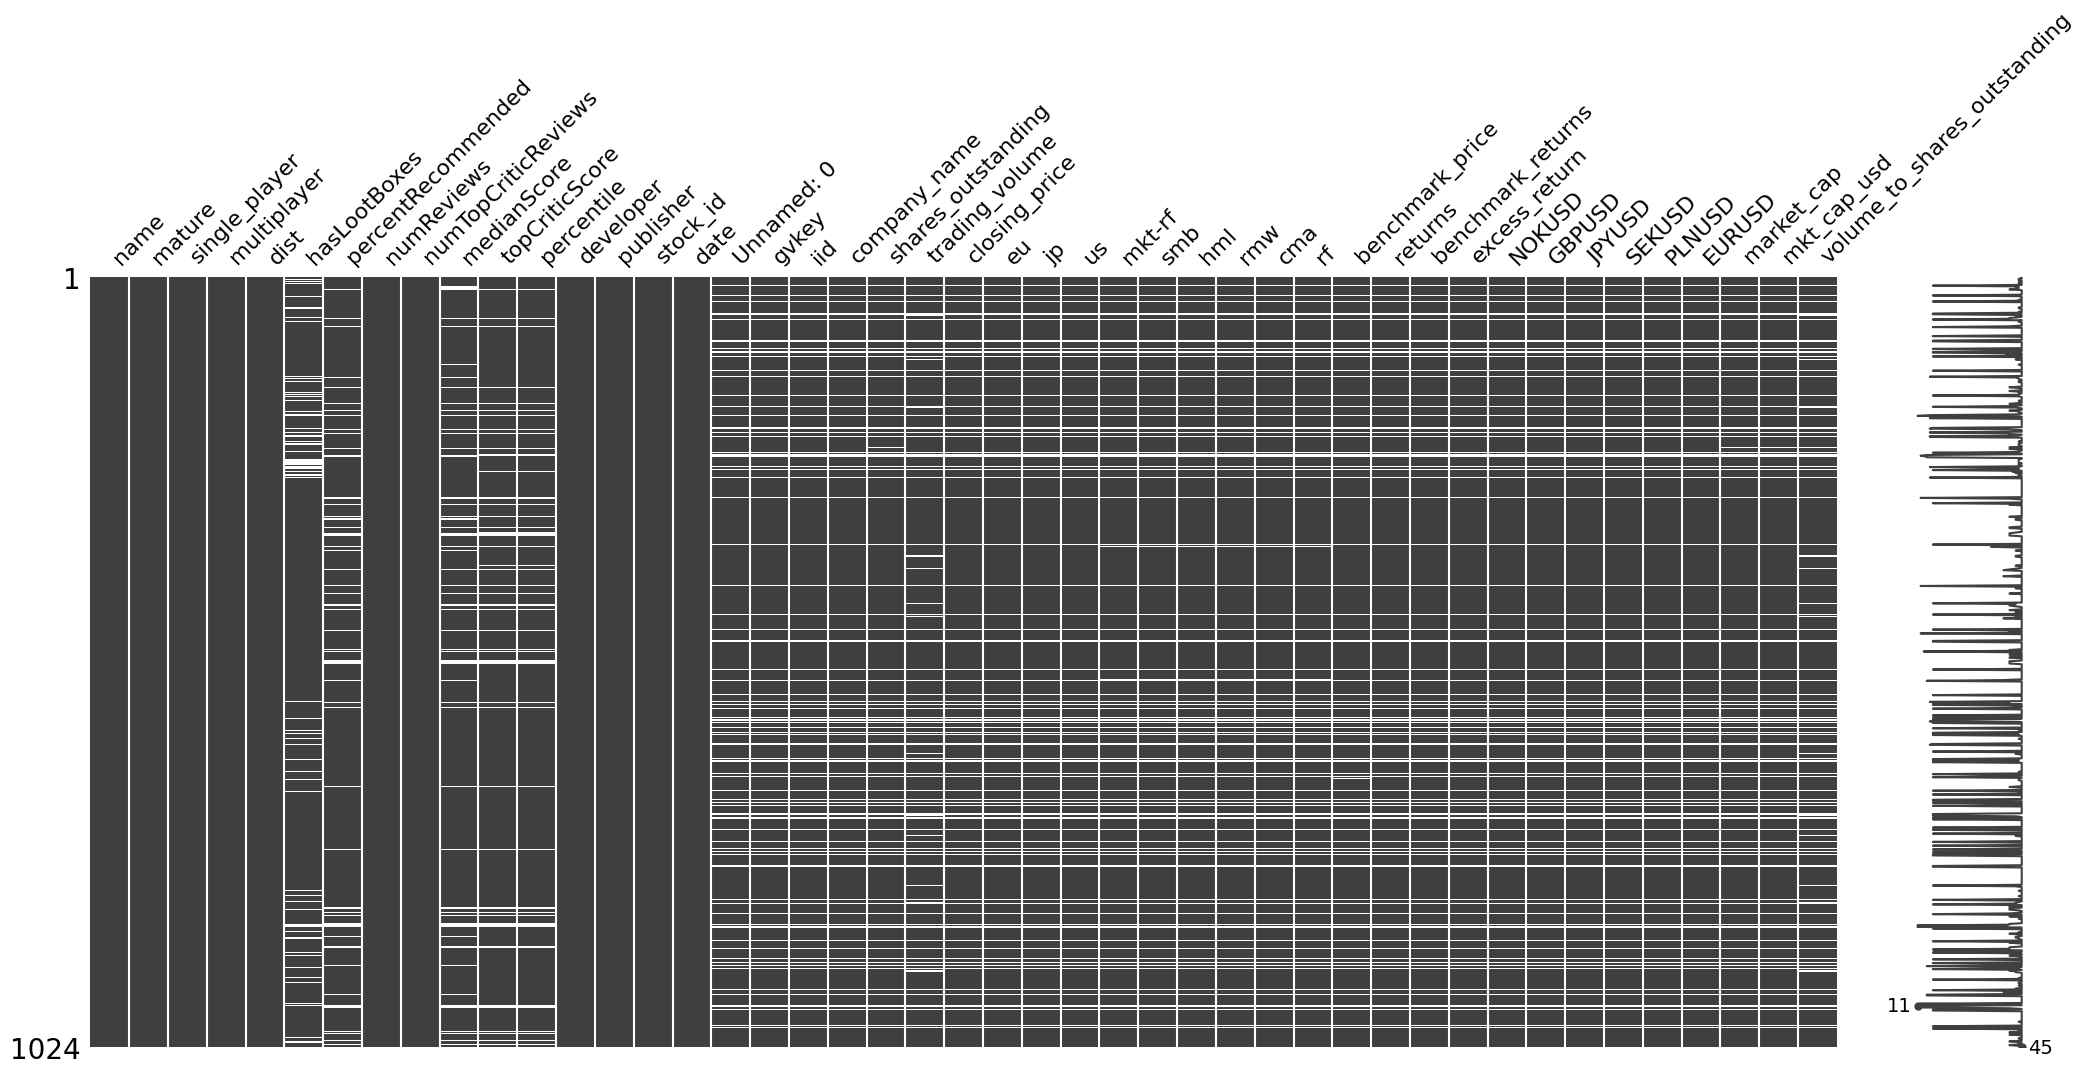

In [476]:
# Plot missing data.
%matplotlib inline

msno.matrix(games_reviews_returns_df)

In [477]:
test = games_reviews_returns_df.groupby('stock_id')['closing_price'].ffill()
test.head()

0   3160.00000
1    263.80000
2   4880.00000
3   4880.00000
4   5650.00000
Name: closing_price, dtype: float64

In [478]:
def forward_fill(df):
    df['stock_id'] = df['stock_id'].ffill()
    df['price'] = df.groupby('stock_id')['price'].ffill()
    df['trading_volume'] = df.groupby('stock_id')['trading_volume'].ffill()
    return df

In [479]:
games_reviews_returns_df = games_reviews_returns_df.dropna()

In [480]:
games_reviews_returns_df.shape

(722, 45)

In [481]:
# Plot missing data.
%matplotlib inline

# msno.matrix(games_reviews_returns_df)

In [482]:
games_reviews_returns_df.columns

Index(['name', 'mature', 'single_player', 'multiplayer', 'dist',
       'hasLootBoxes', 'percentRecommended', 'numReviews',
       'numTopCriticReviews', 'medianScore', 'topCriticScore', 'percentile',
       'developer', 'publisher', 'stock_id', 'date', 'Unnamed: 0', 'gvkey',
       'iid', 'company_name', 'shares_outstanding', 'trading_volume',
       'closing_price', 'eu', 'jp', 'us', 'mkt-rf', 'smb', 'hml', 'rmw', 'cma',
       'rf', 'benchmark_price', 'returns', 'benchmark_returns',
       'excess_return', 'NOKUSD', 'GBPUSD', 'JPYUSD', 'SEKUSD', 'PLNUSD',
       'EURUSD', 'market_cap', 'mkt_cap_usd', 'volume_to_shares_outstanding'],
      dtype='object')

In [483]:
games_reviews_returns_df.describe()[[
    'dist',
    'percentRecommended',
    'numReviews',
    'numTopCriticReviews',
    'medianScore',
    'topCriticScore',
    'percentile'
    ]].style.format({'D':'{:0.5f}'},precision=5).to_latex('games_descriptive_stats.tex')

In [485]:
games_reviews_returns_df.to_csv('games_returns_release_date.csv')

In [486]:
games_reviews_returns_df['stock_id'][games_reviews_returns_df['percentile'] <1]

975    PLFRENT00014
Name: stock_id, dtype: string

In [487]:
# Count the number of games.
games_reviews_returns_df.shape[0]

722

In [488]:
# Count the number of eu companies.
games_reviews_returns_df[games_reviews_returns_df['eu'] == True].shape[0]

205

In [489]:
def country_count(string):
    country_code = 'PL'
    startswith_bool = string.startswith(country_code)
    return startswith_bool

In [490]:
poland_list = games_reviews_returns_df['stock_id'].map(country_count)
poland_list.sum()

44

In [491]:
games_reviews_returns_df.dtypes

name                                    object
mature                                    bool
single_player                             bool
multiplayer                               bool
dist                                   float64
hasLootBoxes                            object
percentRecommended                     float64
numReviews                             float64
numTopCriticReviews                    float64
medianScore                            float64
topCriticScore                         float64
percentile                             float64
developer                                 bool
publisher                                 bool
stock_id                        string[python]
date                            datetime64[ns]
Unnamed: 0                             float64
gvkey                                  float64
iid                             string[python]
company_name                    string[python]
shares_outstanding                     float64
trading_volum

In [492]:
def add_region_name(eu_bool, jp_bool, us_bool):
    if eu_bool:
        return 'eu'
    elif jp_bool:
        return 'jp'
    else:
        return 'us'

In [493]:
def add_dev_pub(dev_bool, pub_bool):
    if dev_bool:
        return 'developer'
    elif pub_bool:
        return 'publisher'
    else:
        return 'neither'

In [494]:
games_reviews_returns_df['region'] = games_reviews_returns_df.apply(lambda x: add_region_name(eu_bool=x['eu'], jp_bool=x['jp'], us_bool=x['us']), axis=1)
games_reviews_returns_df['dev_pub'] = games_reviews_returns_df.apply(lambda x: add_dev_pub(dev_bool=x['developer'], pub_bool=x['publisher']), axis=1)
games_reviews_returns_df.head()

,name,mature,single_player,multiplayer,dist,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,...,GBPUSD,JPYUSD,SEKUSD,PLNUSD,EURUSD,market_cap,mkt_cap_usd,volume_to_shares_outstanding,region,dev_pub
0,The Last Guardian,False,True,False,0.00000,False,70.49180,128.00000,96.00000,85.00000,...,1.27050,0.00874,0.10919,0.23842,1.07250,3991703657600.00000,34891481671.08160,0.00533,jp,publisher
1,Empire of Sin,True,True,False,0.00000,False,27.11864,60.00000,40.00000,62.50000,...,1.33505,0.00959,0.11696,0.26681,1.19620,27857280000.00000,3258243183.36000,0.00142,eu,publisher
4,One Punch Man: A Hero Nobody Knows,False,True,True,0.00000,False,17.10526,76.00000,52.00000,60.00000,...,1.28735,0.00909,0.10361,0.25428,1.09860,1254300000000.00000,11404095600.00000,0.00562,jp,publisher
6,Hatsune Miku: Project Diva Mega Mix,False,True,False,0.00000,False,79.16667,48.00000,30.00000,80.00000,...,1.30540,0.00911,0.10341,0.25506,1.08485,420908801556.00000,3832795546.96894,0.00241,jp,developer
7,Hatsune Miku: Project Diva Mega Mix,False,True,False,0.00000,False,79.16667,48.00000,30.00000,80.00000,...,1.30540,0.00911,0.10341,0.25506,1.08485,420908801556.00000,3832795546.96894,0.00241,jp,publisher


/Users/connor.stevens/.pyenv/versions/3.11.1/envs/venv-thesis/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 49.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/connor.stevens/.pyenv/versions/3.11.1/envs/venv-thesis/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 24.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/Users/connor.stevens/.pyenv/versions/3.11.1/envs/venv-thesis/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 57.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/connor.stevens/.pyenv/versions/3.11.1/envs/venv-thesis/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 33.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


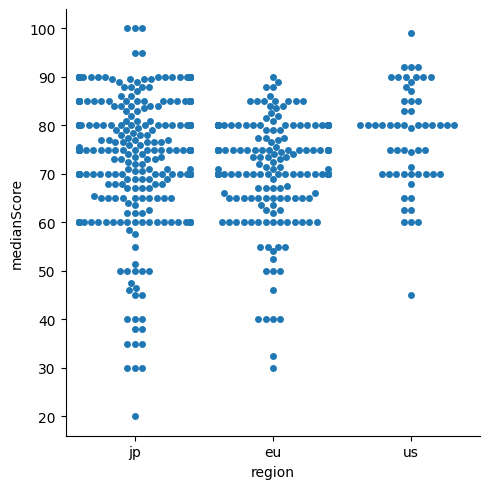

In [495]:
sns.catplot(data=games_reviews_returns_df, x="region", y="medianScore", kind="swarm")

In [496]:
df_test = games_reviews_returns_df.groupby(['eu']).cumcount()
df_test.head()

0    0
1    0
4    1
6    2
7    3
dtype: int64

In [497]:
len(games_reviews_returns_df['name'].unique())

587

In [498]:
games_reviews_returns_df.groupby('name')['stock_id'].count()

name
1-2-Switch                                        2
112 Operator                                      2
A King's Tale: Final Fantasy XV                   1
A Plague Tale: Requiem                            1
A Rose in the Twilight                            1
                                                 ..
Yu-Gi-Oh! Rush Duel: Dawn of the Battle Royale    2
Yume Nikki: Dream Diary                           1
Zorro: The Chronicles                             1
Zumba: Burn it Up!                                1
eFootball 2022                                    2
Name: stock_id, Length: 587, dtype: int64